# Projekat iz neuralnih mreža  
Marija Rakonjac 2020/0222  
Marija Brkić 2020/0200

In [2]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import Sequential
from keras.optimizers.legacy import Adam
from keras.losses import SparseCategoricalCrossentropy
import pandas as pd

## Opis problema:  
Problem ovog zadatka predstavlja klasifikaciju štete na kolima na osnovu datih slika. Klase u koje se klasifikuju oštećenja su sledeće:  
1: crack(naprsnuće)  
2: scratch(ogrebotina)  
3: tire flat(probušena guma)     
4: dent(udubljenje)     
5: glass shatter(razbijeno staklo)  
6: lamp broken(razbijeni far)    


In [78]:
data = pd.read_csv('train/train/train.csv');
print(data.head());
labels_names = {1:'crack', 2:'scratch', 3:'tire flat', 4:'dent', 5:'glass shatter', 6:'lamp broken'};
print(labels_names);

   image_id filename  label
0         1    1.jpg      2
1         2    2.jpg      4
2         3    3.jpg      2
3         4    4.jpg      3
4         5    5.jpg      5
{1: 'crack', 2: 'scratch', 3: 'tire flat', 4: 'dent', 5: 'glass shatter', 6: 'lamp broken'}


Podaci su dati u obliku foldera sa slikama i csv fajla u kome svaki red odgovara informacijama za po jednu sliku, gde se prva kolona odnosi na ID slike, druga na naziv fajla u kome je smeštena slika i treća na klasu kojoj pripada ta slika(labela).

In [5]:
from PIL import Image

In [21]:
def image_load(path):
    image = Image.open(path);
    image = image.resize((400,300))
    image = np.array(image);
    return image;


In [22]:
path_beg = 'train/train/images/'
images = [];
labels = [];
is_printed = {};
for i in range(6):
    is_printed[i+1]=False;
print(is_printed)

{1: False, 2: False, 3: False, 4: False, 5: False, 6: False}


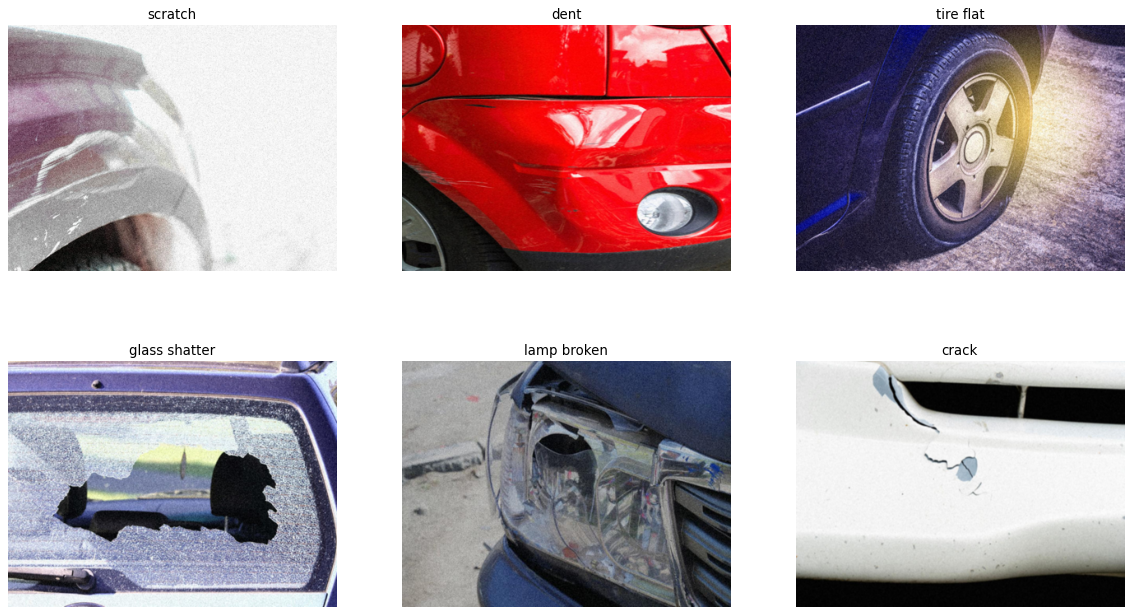

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), dpi=80)
j = 0;
k = 0;
for i in range(data.shape[0]):
    path = path_beg + data.iloc[i,:].filename;
    image = image_load(path);
    images.append(image);
    labels.append(data.iloc[i,:].label);
    if(is_printed[data.iloc[i,:].label]==False):
        axes[j,k].imshow(image, cmap='jet'), axes[j,k].set_title(labels_names[data.iloc[i,:].label]), axes[j,k].axis('off');
        k+=1;
        if(k==3):
            j+=1;
            k=0;
        is_printed[data.iloc[i,:].label]=True;
plt.show()    

Na prethodnom grafiku su prikazani primerci svake od klasa.

In [25]:
images = np.array(images)
labels = np.array(labels)

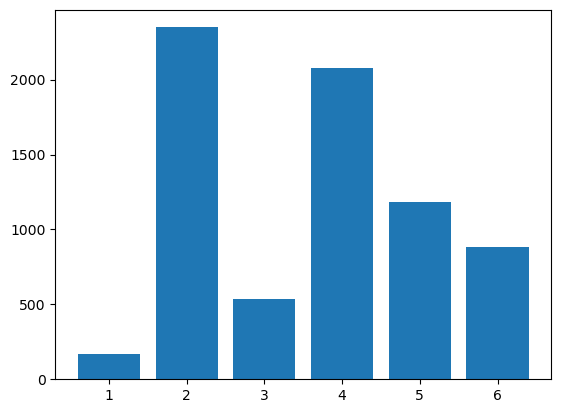

label
2    2349
4    2079
5    1185
6     882
3     534
1     171
Name: count, dtype: int64


In [26]:
plt.figure();
count = data.label.value_counts()
plt.bar(count.index,count.values);
plt.show();
print(count);

## Balansiranost klasa
Na prethodnom grafiku je dat histogram na kome vidimo broj slika u okviru svake klase. Klase su primetno nebalansirane, te je potrebno primeniti neku metodu za balansiranje. Metoda koju ćemo mi koristiti je class weights, metod koji pri treniranju mreže daje različite težine klasama u skladu sa brojem podataka. Alternative bi bile oversampling i undersampling, koje bi podrazumevale da se iseče broj odbiraka ili da se sintetički stvore novi, što u ovom slučaju nama ne odgovara. Pored toga, klasa 1 ima manje od 5% ukupnog broja odbiraka pa će u daljoj obradi ona biti potpuno zanemarena.

1 crack 171
   image_id filename  label
0         1    1.jpg      2
1         2    2.jpg      4
2         3    3.jpg      2
3         4    4.jpg      3
4         5    5.jpg      5


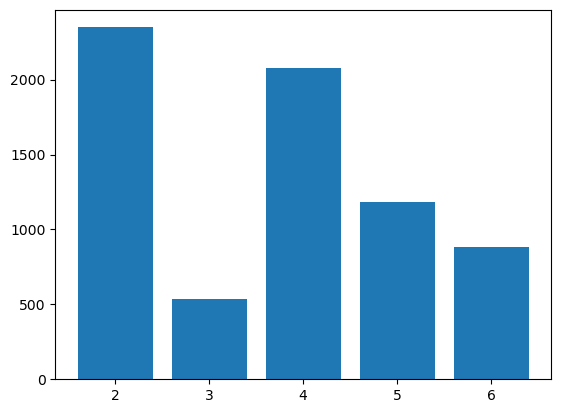

label
2    2349
4    2079
5    1185
6     882
3     534
Name: count, dtype: int64


In [27]:
count_all = data.shape[0];
for i in range(6):
    if(count.values[i]<0.05*count_all):
        print(count.index[i], labels_names[count.index[i]], count.values[i]);
        images = images[labels!=count.index[i]];
        labels = labels[labels!=count.index[i]];
        data.drop(data[data.label == count.index[i]].index, inplace=True);
        
labels = labels-2;
print(data.head());
plt.figure();
count = data.label.value_counts()
plt.bar(count.index,count.values);
plt.show();
print(count);

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [29]:
imagesTrain, imagesTest, labelsTrain, labelsTest = train_test_split(images, labels, test_size=0.2, random_state=42)
imagesTrain, imagesVal, labelsTrain, labelsVal = train_test_split(imagesTrain, labelsTrain, test_size=0.2, random_state=42)

## Podela podataka na skupove
Podatke delimo na trening, test i validacioni skup. Treniranje mreže vršimo na trening skupu, dok podešavanje hiperparametara vršimo na osnovu rezultata validacionog skupa. Konačno testiranje se vrši na test skupu, što se izvršava samo jednom, na kraju čitavog procesa. Ova podela je od ključnog značaja, kako se ne bi mreža i trenirala i testirala na istom skupu podataka, jer iako se ona dobro naučila da prepoznaje odbirke trening skupa, ne znači da bi imala iste performanse i na potpuno novim odbircima. Ideja korišćenja validacionog skupa je da se nakon treniranja vrši validacija na osnovu koje menjamo parametre mreže. Zato je bitno da se testiranje vrši samo jednom, kako se ne bi nikakvo učenje vršilo nad test skupom i kako bi se dobio nepristrasan rezultat. U našem slučaju, test skup uzima 20% ukupnog broja odbiraka. Preostalih 80% odbiraka smo podelili na trening i validacioni skup, gde validacioni skup uzima 20%, a trening 80% preostalih podataka. Takođe je bitno da svaki od tih skupova sadrži približan broj odbiraka svake klase, zbog čega pri podeli vršimo mešanje podataka, iako su podaci u samoj početnoj bazi bili izmešani.

In [30]:
weights = class_weight.compute_class_weight(class_weight='balanced', 
                                            classes=np.unique(labelsTrain), 
                                            y=labelsTrain)

In [34]:
img_size = [300, 400]
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_size[0], 
                                                 img_size[1], 3)),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.1),
  ]
)

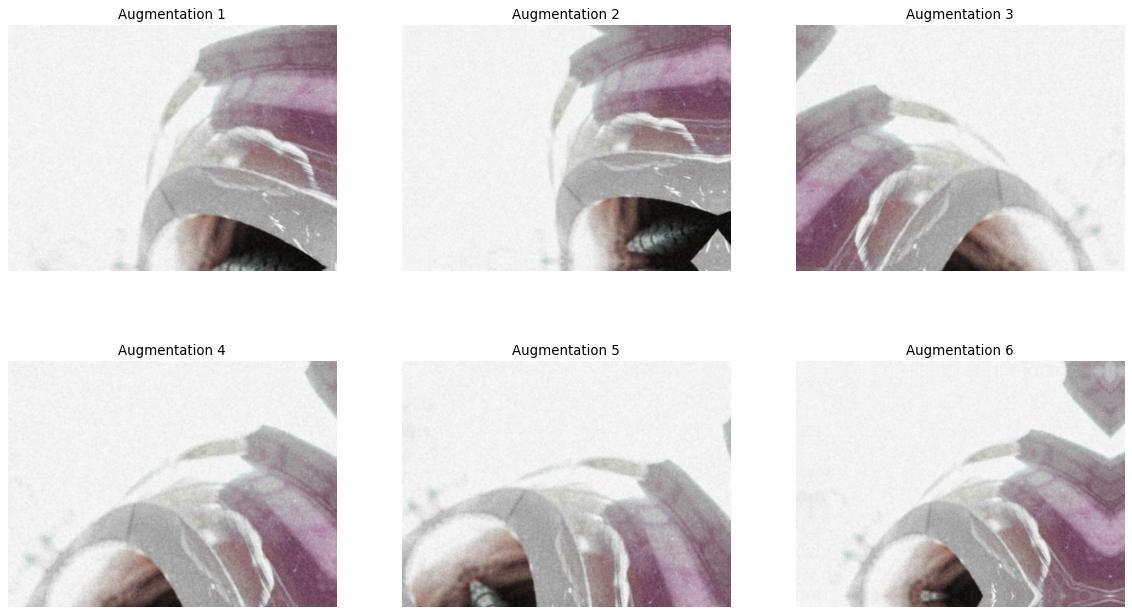

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), dpi=80)
img = images[0,:,:,:];
img_with_batch = img.reshape((1,300,400,3))
for i in range(2):
    for j in range(3):
        aug_img = data_augmentation(img_with_batch);
        num = i*3+j+1;
        axes[i,j].imshow(aug_img[0].numpy().astype('uint8'), cmap='jet'), axes[i,j].set_title('Augmentation '+ str(num)), axes[i,j].axis('off');

Prethodni grafik predstavlja različite augmentacije nad jednom od ulaznih slika. Kao tipovi promena na slici su korišćeni obrtanje, rotacija i zumiranje slike. Međutim, primenom augmentacije, treniranje je bilo otežano. Takođe, korišćena je metoda dropout kao vid regularizacije, a i broj podataka je zadovoljavajuć za trening mreže, te smo odlučili da je ova metoda suvišna.

## Pretprocesiranje podataka
Što se tiče predobrade podataka, pri samom učitavanju slika smo smanjili rezoluciju na (300,400), kako bi sve slike bile iste veličine, kao i radi lakšeg treniranja. Pored toga, intenzitete svakog piksela smo sa opsega (0,255) sveli na opseg (0,1).

In [42]:
num_classes = 5;
model = Sequential([
    #data_augmentation,
    layers.Rescaling(1./255, input_shape=(300, 400, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(Adam(learning_rate=0.001), 
              loss=SparseCategoricalCrossentropy(),
              metrics='accuracy')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 300, 400, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 300, 400, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 150, 200, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 150, 200, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 75, 100, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 75, 100, 64)      

## Arhitektura mreže
Korišćena mreža na početku reskalira podatke na opseg (0,1). Nakon toga sledi pet konvolucionih slojeva, a između svaka dva postoji MaxPooling sloj.  
Konvolucioni slojevi imaju čvorove se filtrima dimenzija 3x3 kojima se vrši konvolucija sa svakim kanalom ulazne slike. Na taj način se vrši izdvajanje obeležja na osnovu kojih bi na kraju mreže bila moguća klasifikacija. U tim čvorovima se takođe koristi i ReLU aktivaciona funkcija. ReLU aktivaciona funcija je najkorišćenija zbog toga što rešava problem saturacije i ima dovoljno veliki i konstantan gradijent. U prvom konvolucionom sloju ima 16 čvorova, a u svakom narednom 2 puta više od prethodnog.  
MaxPooling sloj sadrži filtar 2x2 koji izdvaja piksel maksimalnog intenziteta u okviru datog prozora. Na taj način se efektivno izdvajaju najbitnija obeležja.  
Nakon toga poziva se funkcija kojom se vrši dropout, koji podrazumeva da se u svakom batch-u ne obrađuju nasumično odabrani čvorovi, sa verovatnoćom 0.2. Ovo je jedan od metoda regularizacije koji obezbeđuju bolje treniranje mreže.  
Na kraju mreže su korišćena dva fully connected sloja, pri čemu u prvom postoji 64 čvora, i takođe se koristi ReLU aktivaciona funkcija, dok u poslednjem postoji onoliko čvorova koliko ima i klasa(5) i kao aktivaciona funkcija se koristi Softmax. Softmax je karakteristična aktivaciona funkcija u slučaju klasifikacije na više klasa. Izlaz iz svakog čvora predstavlja verovatnoću pripadnosti svakoj od klasa, a za predikciju se usvaja klasa sa najvećom verovatnoćom.  
Za metodu optimizacije se koristi ADAM(Adaptive Moment Estimation) optimizator koji kombinuje Momentum i RMSProp metode, koje pomažu da se promene gradijenata vrši u istom smeru i da budu prikladno skalirane.  
Kao kriterijumska funkcija se primenjuje SparseCategoricalCrossentropy koja je bazirana na konceptu maksimalne verodostojnosti, kao i kod BinaryCrossentropy, samo za više od dve klase, kada nije primenjen OneHotEncoding.  
U ispisu iznad je prikazan broj parametara u svakom sloju, kao i ukupan broj parametara u celoj mreži.

In [39]:
print(weights)

[0.59853626 2.63040936 0.67486872 1.18837517 1.59786856]


In [43]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(imagesTrain, 
                    labelsTrain,
                    epochs=20,
                    batch_size=64,
                    class_weight={0:weights[0], 1:weights[1], 2:weights[2], 3:weights[3], 4:weights[4]},
                    validation_data=(imagesVal, labelsVal),
                    callbacks=[es],
                    verbose=1)

Epoch 1/20
71/71 [==============================] - 275s 4s/step - loss: 1.5860 - accuracy: 0.2561 - val_loss: 1.3755 - val_accuracy: 0.4000
Epoch 2/20
71/71 [==============================] - 274s 4s/step - loss: 1.2325 - accuracy: 0.4233 - val_loss: 1.2930 - val_accuracy: 0.4533
Epoch 3/20
71/71 [==============================] - 273s 4s/step - loss: 1.0330 - accuracy: 0.5180 - val_loss: 1.1325 - val_accuracy: 0.4951
Epoch 4/20
71/71 [==============================] - 271s 4s/step - loss: 0.8750 - accuracy: 0.5625 - val_loss: 0.9687 - val_accuracy: 0.5733
Epoch 5/20
71/71 [==============================] - 274s 4s/step - loss: 0.7631 - accuracy: 0.6187 - val_loss: 0.9753 - val_accuracy: 0.5840
Epoch 6/20
71/71 [==============================] - 274s 4s/step - loss: 0.6261 - accuracy: 0.6861 - val_loss: 0.9149 - val_accuracy: 0.6427
Epoch 7/20
71/71 [==============================] - 270s 4s/step - loss: 0.4752 - accuracy: 0.7561 - val_loss: 0.9960 - val_accuracy: 0.6418
Epoch 8/20
71

## Zaštita od preobučavanja
U slučaju da se mreža previše obuči nad trening skupom, i adaptira na te podatke, dolazi do problema preobučavanja. Posledica je velika tačnost na trening skupu, a izuzetno mala na validacionom i test skupu. To bi se moglo primetiti na grafiku loss funkcije validacionog i trening skupa, ako bi vrednost kod trening skupa sve vreme opadala, dok bi za validacioni počela da raste. Primenjena metoda za rešavanje ovog problema, pored dropout-a, je EarlyStopping, koja prati tačnost nad validacionim skupom, i ukoliko ona opada određeni broj epoha, zaustavlja treniranje i čuva vrednosti težina koje su dale najbolju tačnost. U našem slučaju se prekida treniranje nakon 5 epoha u kojima opada tačnost na validacionom skupu.

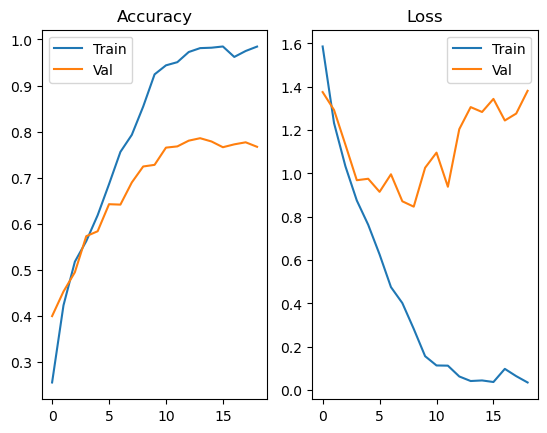

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.subplot(121)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Accuracy')
plt.legend(['Train', 'Val'])
plt.subplot(122)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss')
plt.legend(['Train', 'Val'])
plt.show()

## Analiza rezultata
Na prethodnim graficima je prikazana tačnost i vrednost loss funkcije kroz epohe na trening i validacionom skupu. Na trening skupu vidimo da tačnost i loss funkcija dostižu željene vrednosti, dok tačnost validacionog skupa dostiže oko 80% i počinje blago da opada, a loss funkcija da raste. Ovo je verovatno posledica preobučavanja, ili jednostavno najbolji rezultat koji se postiže nad ovom bazom podataka.

In [57]:
labelsPred = model.predict(imagesTest, verbose=0)

In [59]:
labelsPred = np.argmax(labelsPred, axis=1)

In [63]:
from sklearn.metrics import accuracy_score
print('Tačnost modela je: ' + str(100*accuracy_score(labelsTest, labelsPred)) + '%')

Tačnost modela je: 79.23186344238977%


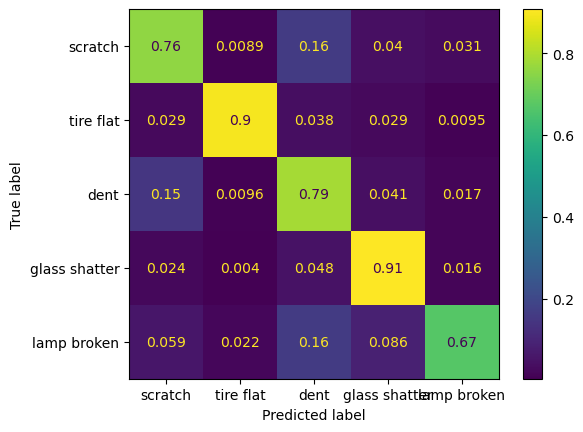

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels_names1 = ['scratch', 'tire flat', 'dent', 'glass shatter', 'lamp broken'];
cm = confusion_matrix(labelsTest, labelsPred, normalize='true')
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names1)
cmDisplay.plot()
plt.show()

Tačnost modela je: 99.53312583370388%


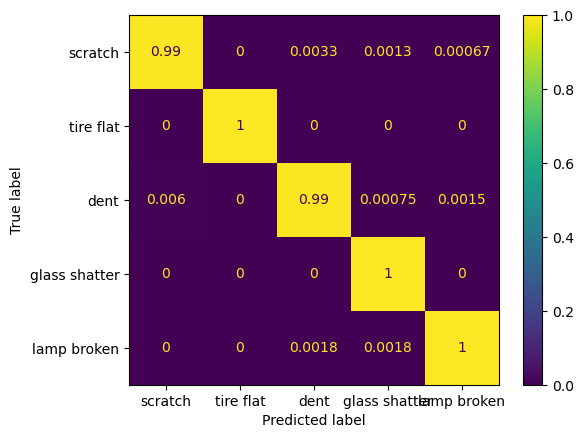

In [67]:
labelsPredTrain = model.predict(imagesTrain, verbose=0)
labelsPredTrain = np.argmax(labelsPredTrain, axis=1)
print('Tačnost modela je: ' + str(100*accuracy_score(labelsTrain, labelsPredTrain)) + '%')
labels_names1 = ['scratch', 'tire flat', 'dent', 'glass shatter', 'lamp broken'];
cm = confusion_matrix(labelsTrain, labelsPredTrain, normalize='true')
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names1)
cmDisplay.plot()
plt.show()

Prva konfuziona matrica se odnosi na test skup, dok se druga odnosi na trening skup, i sasvim očekivano su dosta bolji rezultati na trening skupu. Tačnost modela na test skupu je oko 80%, što je značajan napredak u odnosu na slučajan izbor klase. Iz konfuzione matrice se vidi da sistem slabije razlikuje udubljenje i ogrebotinu, što bi moglo biti očekivano.

In [76]:
is_printed_true = {};
is_printed_false = {};
for i in range(5):
    is_printed_true[i]=False;
    is_printed_false[i]=False;
labels_names2 = {0:'scratch', 1:'tire flat', 2:'dent', 3:'glass shatter', 4:'lamp broken'};

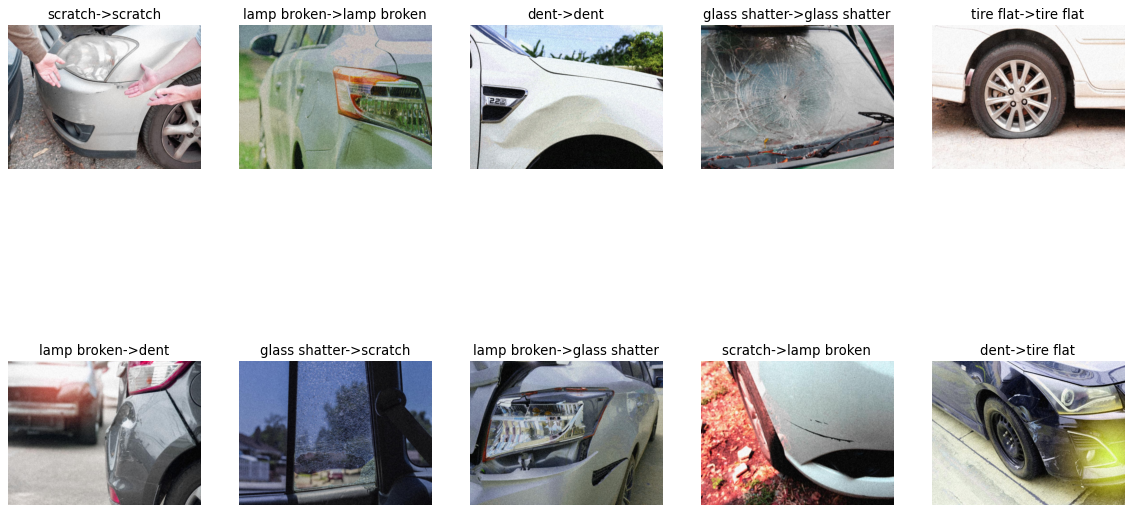

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 10), dpi=80)
j=0
k=0
for i in range(len(labelsPred)):
    if(labelsPred[i]==labelsTest[i]):
        if(is_printed_true[labelsPred[i]]==False):
            axes[0,j].imshow(imagesTest[i], cmap='jet'), axes[0,j].set_title(labels_names2[labelsPred[i]] + '->' + labels_names2[labelsPred[i]]), axes[0,j].axis('off');
            j+=1
            is_printed_true[labelsPred[i]]=True
    else:
        if(is_printed_false[labelsPred[i]]==False):
            axes[1,k].imshow(imagesTest[i], cmap='jet'), axes[1,k].set_title(labels_names2[labelsTest[i]] + '->' + labels_names2[labelsPred[i]]), axes[1,k].axis('off');
            k+=1
            is_printed_false[labelsPred[i]]=True

Na prethodnim slikama se vide primeri dobro i loše klasifikovanih odbiraka za svaku klasu. Što se tiče loše klasifikovanih odbiraka, slike predstavljaju slučajeve koje mogu biti teže za klasifikaciju i ljudskom oku, ili primere koji su slikani iz unutrašnjosti kola, što inače nije slučaj.

Za dalje poboljšanje mreže bi eventualno mogla da se primeni veća ili drugačija arhitektura mreže, ili da se proširi skup podataka slikama koje pokrivaju specifične slučajeve, ali zaključak je da je i trenutna tačnost za naše potrebe dovoljno dobra.